In [1]:
import os
import shutil
import random

real_images_path = r'C:\Users\dekat\Downloads\archive\real_and_fake_face\training_real'
fake_images_path = r'C:\Users\dekat\Downloads\archive\real_and_fake_face\training_fake'

train_real_path = r'C:\Users\dekat\downloads\train real'
train_fake_path = r'C:\Users\dekat\Downloads\train fake'
val_real_path = r'C:\Users\dekat\Downloads\val real'
val_fake_path = r'C:\Users\dekat\Downloads\val fake'

os.makedirs(train_real_path, exist_ok=True)
os.makedirs(train_fake_path, exist_ok=True)
os.makedirs(val_real_path, exist_ok=True)
os.makedirs(val_fake_path, exist_ok=True)

def split_data(image_folder, train_folder, val_folder, val_ratio=0.2):
    # List all image files in the folder
    images = [f for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png'))]
    
   
    random.shuffle(images)
    
   
    split_index = int(len(images) * (1 - val_ratio))
    
  
    for image in images[:split_index]:
        shutil.copy(os.path.join(image_folder, image), train_folder)
    
   
    for image in images[split_index:]:
        shutil.copy(os.path.join(image_folder, image), val_folder)


split_data(real_images_path, train_real_path, val_real_path)
split_data(fake_images_path, train_fake_path, val_fake_path)

print("Dataset has been split into training and validation sets.") 

Dataset has been split into training and validation sets.


In [7]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [8]:
train_dir= r'C:\Users\dekat\Downloads\training 2'
validation_dir=r'C:\Users\dekat\Downloads\validation 2'

In [9]:
train_datagen = ImageDataGenerator(
    rescale=1./255,  
    rotation_range=40,  
    width_shift_range=0.2,  
    height_shift_range=0.2,  
    shear_range=0.2,  
    zoom_range=0.2,  
    horizontal_flip=True,  
    fill_mode='nearest' 
)
validation_datagen = ImageDataGenerator(rescale=1./255) 
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),  
    batch_size=32,  
    class_mode='binary' 
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150), 
    batch_size=32,  
    class_mode='binary'  
)

Found 1954 images belonging to 2 classes.
Found 731 images belonging to 2 classes.


In [14]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150,3))

x = base_model.output
x = GlobalAveragePooling2D()(x) 
x = Dense(1024, activation='relu')(x)  
x = Dense(1, activation='sigmoid')(x)  

model = Model(inputs=base_model.input, outputs=x)

for layer in base_model.layers:
    layer.trainable = False


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

C:\Users\dekat\AppData\Local\Temp\ipykernel_3084\1591962865.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150,3))


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 150, 150, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 75, 75, 32)        │             864 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 75, 75, 32)        │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 75, 75, 32)        │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 75, 75, 32)        │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 75, 75, 32)        │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 75, 75, 32)        │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 75, 75, 16)        │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 75, 75, 16)        │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 75, 75, 96)        │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 75, 75, 96)        │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 75, 75, 96)        │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 77, 77, 96)        │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 38, 38, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 3,570,753 (13.62 MB)

 Trainable params: 1,312,769 (5.01 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [16]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5, min_lr=0.001)


base_model.trainable = True
fine_tune_at = 100 

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss='binary_crossentropy',  
              metrics=['accuracy'])


history_fine_tune = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=15,  
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[early_stopping, lr_reduction]
)

# Optionally, print out the validation accuracy and loss
print("Final validation accuracy:", history_fine_tune.history['val_accuracy'][-1])

C:\Users\dekat\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.5151 - loss: 0.7477 - val_accuracy: 0.5390 - val_loss: 0.6852 - learning_rate: 1.0000e-05
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.5376 - loss: 0.7023 - val_accuracy: 0.5828 - val_loss: 0.6652 - learning_rate: 1.0000e-05
Epoch 3/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.5556 - loss: 0.6820 - val_accuracy: 0.6252 - val_loss: 0.6509 - learning_rate: 1.0000e-05
Epoch 4/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.5997 - loss: 0.6716 - val_accuracy: 0.6525 - val_loss: 0.6416 - learning_rate: 1.0000e-05
Epoch 5/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.5942 - loss: 0.6735 - val_accuracy: 0.6539 - val_loss: 0.6340 - learning_rate: 1.0000e-05
Epoch 6/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - accuracy: 0.5806 - loss: 0.6796 - val_accuracy: 0.6553 - val_loss: 0.6325 - learning_rate: 1.0000e-05
Epoch 7/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.6104 

In [18]:
model.save('my_model.keras')
from tensorflow.keras.models import load_model

# Load the model saved in the .keras format
model = load_model('my_model.keras')


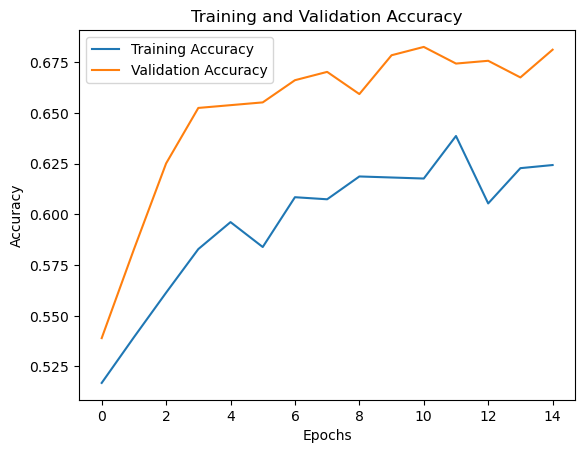

Final validation accuracy: 0.6812585592269897


In [19]:
import matplotlib.pyplot as plt

plt.plot(history_fine_tune.history['accuracy'], label='Training Accuracy')
plt.plot(history_fine_tune.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()


print("Final validation accuracy:", history_fine_tune.history['val_accuracy'][-1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
Predicted Class: Fake with probability: 0.6840565


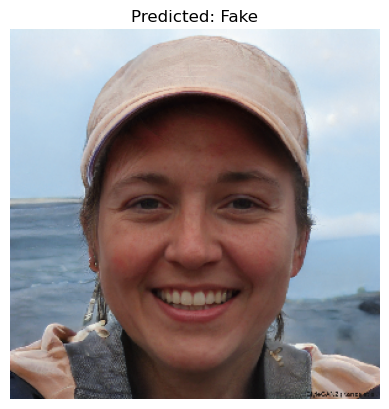

In [58]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt


img_path = r'C:\Users\dekat\Downloads\download.jpeg'

img = image.load_img(img_path, target_size=(300, 300))  # Resize to match model input
img_array = image.img_to_array(img)  # Convert the image to a numpy array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize the image to [0, 1] range (same as training data)

prediction = model.predict(img_array)

if prediction >= 0.5:
    print("Predicted Class: Fake with probability:", prediction[0][0])
else:
    print("Predicted Class: Real with probability:", 1 - prediction[0][0])

plt.imshow(img)
plt.title(f"Predicted: {'Fake' if prediction >= 0.5 else 'Real'}")
plt.axis('off')  # Turn off axis
plt.show()